<h1 style="text-align:center;font-size:48pt;color:#f1faee; text-shadow: 0px 0px 8px #101010;">Walmart Sales Forecasting</h1>

In [4]:
#Import Important libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import plotly.express as px
# from fbprophet.plot import plot_plotly, plot_components_plotly
# from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose as sd
import plotly.graph_objects as go
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import missingno as msno
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load our data

features = pd.read_csv("../data/features.csv", parse_dates=['Date'])
stores = pd.read_csv("../data/stores.csv")
train = pd.read_csv("../data/train.csv", parse_dates=['Date'])
test = pd.read_csv("../data/test.csv", parse_dates=['Date'])

In [6]:
# Display the first 3 rows

print(features.head(3))
print('\n')
print(stores.head(3))
print('\n')
print(train.head(3))

   Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05        42.31       2.572        NaN        NaN        NaN   
1      1 2010-02-12        38.51       2.548        NaN        NaN        NaN   
2      1 2010-02-19        39.93       2.514        NaN        NaN        NaN   

   MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN  211.289143         8.106      False  


   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392


   Store  Dept       Date  Weekly_Sales  IsHoliday
0      1     1 2010-02-05      24924.50      False
1      1     1 2010-02-12      46039.49       True
2      1     1 2010-02-19      41595.55      False


In [7]:
# Display the dataset shape

print(features.shape)
print(stores.shape)
print(train.shape)

(8190, 12)
(45, 3)
(421570, 5)


In [8]:
# We will merge our datasets

tdf = train.merge(features, 'left').merge(stores, 'left')

In [9]:
# Merged data head

tdf.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [10]:
# Display general information

tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [11]:
# Data Description

tdf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
MarkDown1,150681.0,7246.420196,8291.221345,0.270,2240.270000,5347.45000,9210.900000,88646.760000
MarkDown2,111248.0,3334.628621,9475.357325,-265.760,41.600000,192.00000,1926.940000,104519.540000
MarkDown3,137091.0,1439.421384,9623.078290,-29.100,5.080000,24.60000,103.990000,141630.610000
MarkDown4,134967.0,3383.168256,6292.384031,0.220,504.220000,1481.31000,3595.040000,67474.850000
MarkDown5,151432.0,4628.975079,5962.887455,135.160,1878.440000,3359.45000,5563.800000,108519.280000


In [12]:
# Percentage of missing Values

tdf.isna().sum()/len(tdf)*100

Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday        0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
Type             0.000000
Size             0.000000
dtype: float64

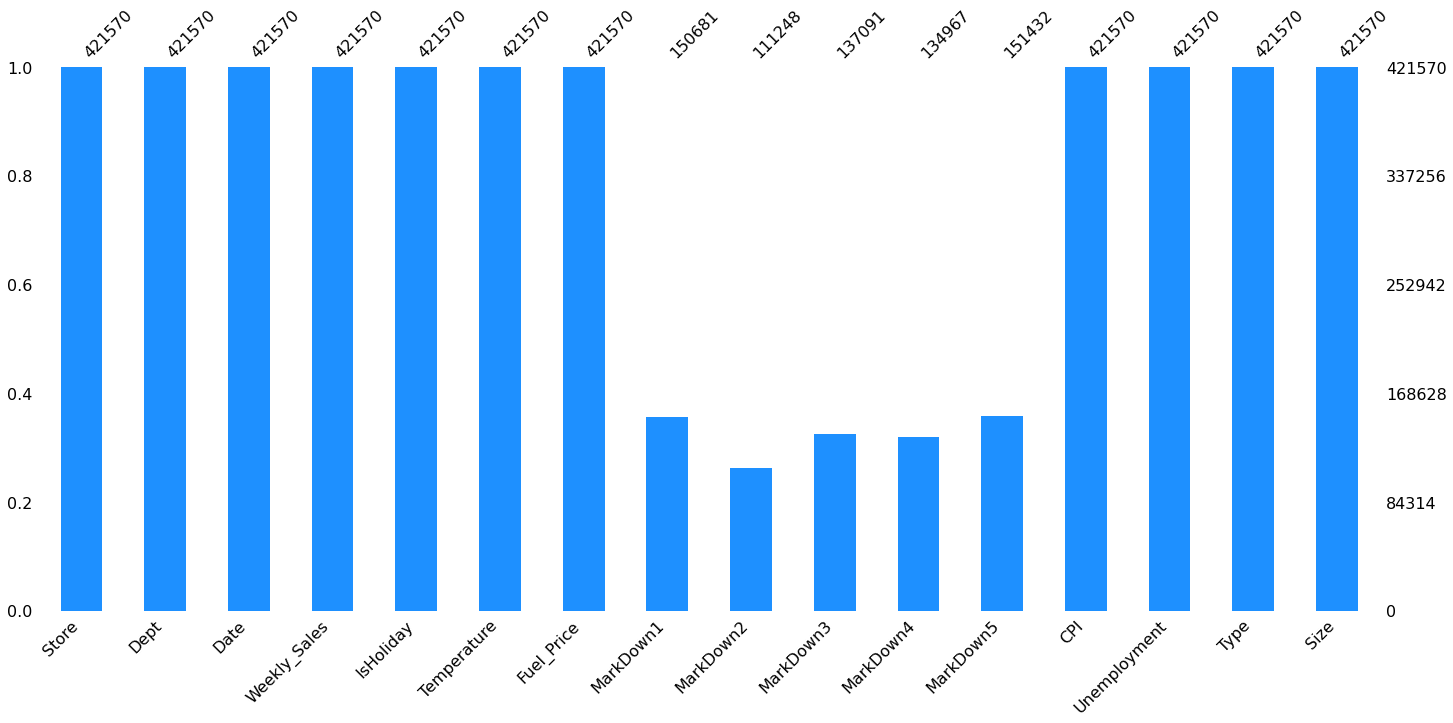

In [13]:
# Visualize our missing data

msno.bar(tdf, color="dodgerblue")
plt.show()

# IMPUTING MISSING DATA

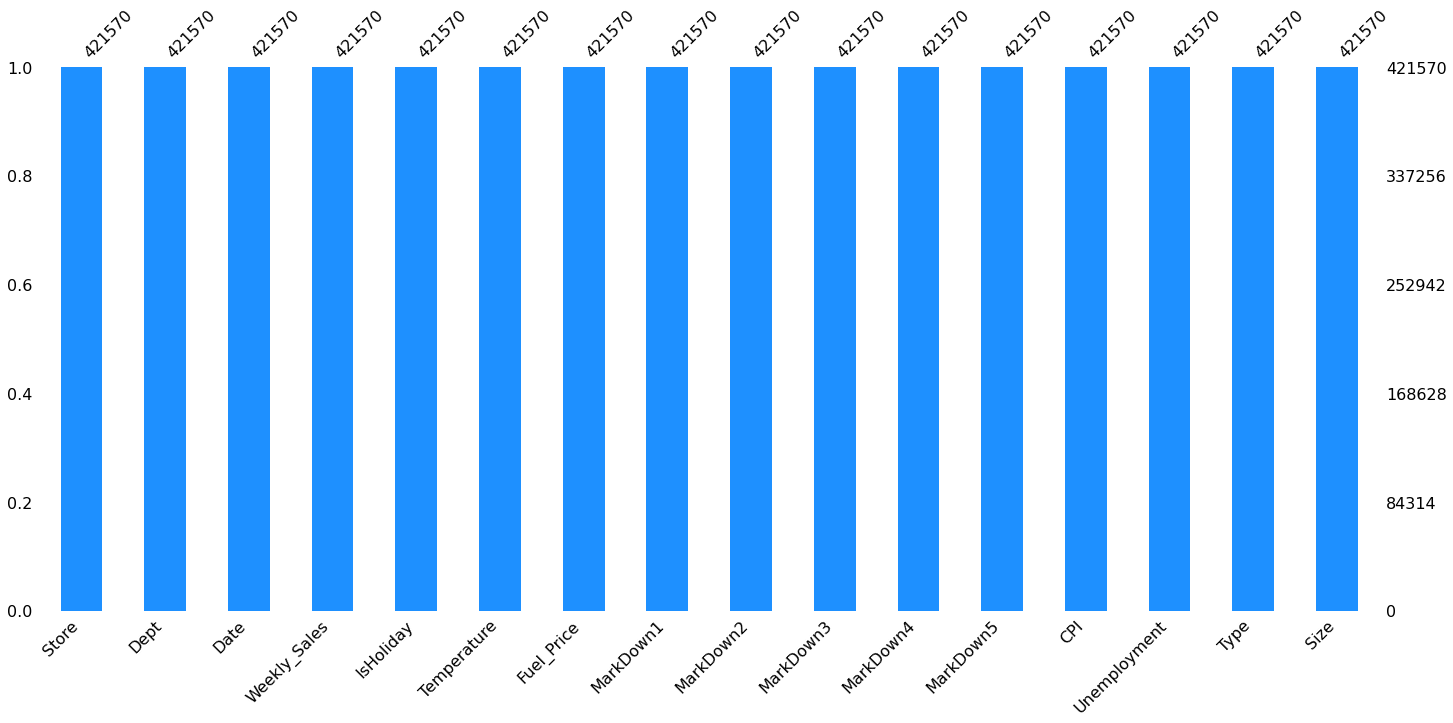

In [14]:
# Missing data is for Markdowns only (Quantitative veriables). We can imput the missing data 
# using a 0, which indicates that there is no markdown.

tdf= tdf.fillna(0)
# DISPLAY MISSING DATA
msno.bar(tdf, color="dodgerblue")
plt.show()

<AxesSubplot:>

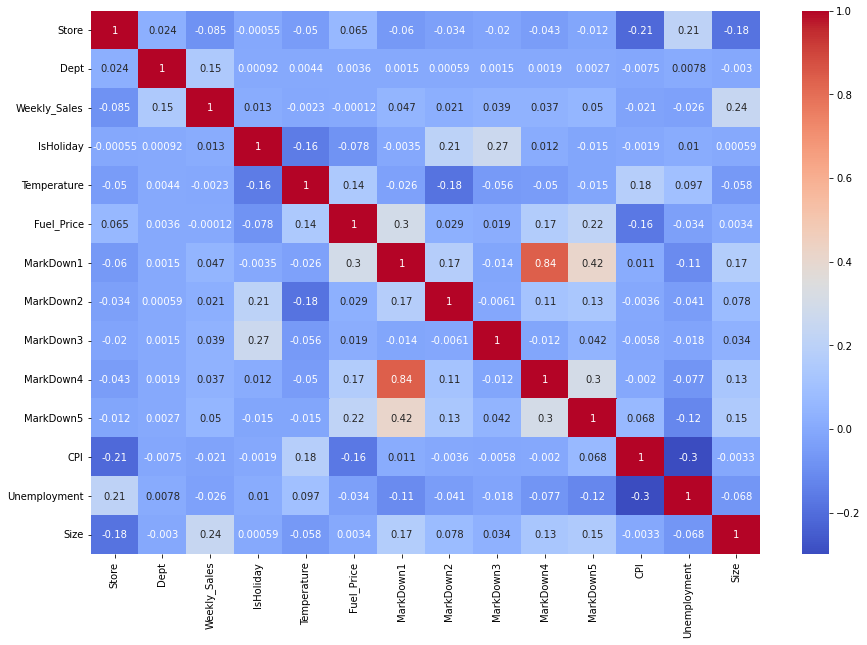

In [15]:
# Correlation matrix

plt.figure(figsize= (15,10))
sns.heatmap(tdf.corr(), annot= True, cmap= 'coolwarm')

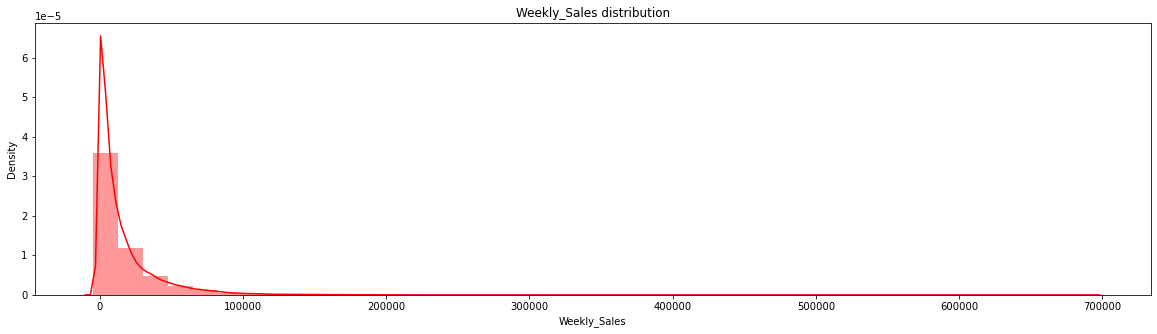

In [16]:
# DISTRIBUTION OF THE DEPENDENT VARIABLE

plt.figure(figsize=(20,5))
sns.distplot(tdf['Weekly_Sales'], bins=40, kde=True, color='red')
plt.title('Weekly_Sales distribution')
plt.show()

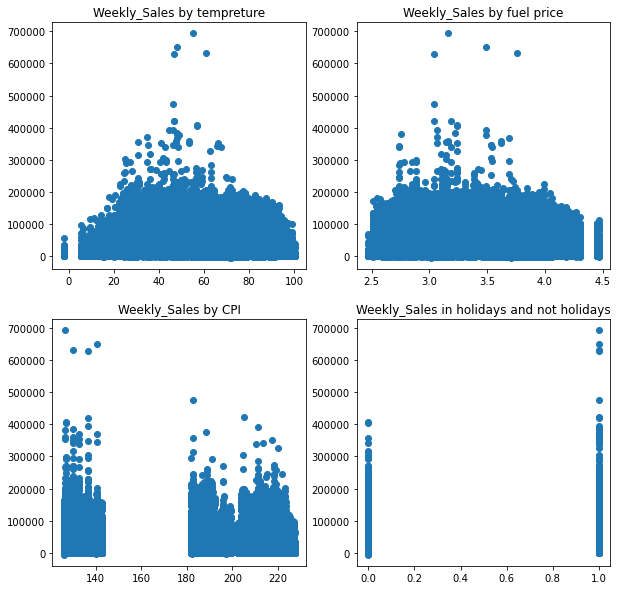

In [17]:
# Sales by different variables

fig, ax = plt.subplots(2, 2, figsize= (10,10))
ax[0,0].scatter(tdf['Temperature'], tdf['Weekly_Sales'])
ax[0,0].set_title('Weekly_Sales by tempreture')
ax[0,1].scatter(tdf['Fuel_Price'], tdf['Weekly_Sales'])
ax[0,1].set_title('Weekly_Sales by fuel price')
ax[1,0].scatter(tdf['CPI'], tdf['Weekly_Sales'])
ax[1,0].set_title('Weekly_Sales by CPI')
ax[1,1].scatter(tdf['IsHoliday'], tdf['Weekly_Sales'])
ax[1,1].set_title('Weekly_Sales in holidays and not holidays')
plt.show()

 # Modeling

## Decomposing Time Series Data into Trend and Seasonality
A Series is an aggregate or combination of 4 components. All series have a level and noise. The trend and seasonality components are optional.
* Level: The average value in the series.
* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Noise: The random variation in the series.

In [18]:
ts=train.groupby("Date")["Weekly_Sales"].sum()

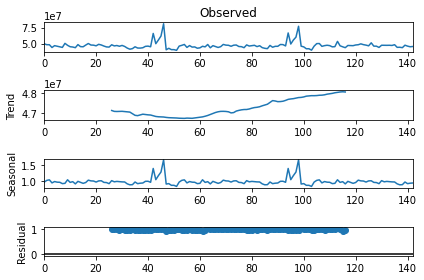

In [19]:
# Visualize Residuals, Seasonal, Trend, and level

res = sm.tsa.seasonal_decompose(ts.values,period=52,model="multiplicative")
res.plot()
plt.show()

here we can see a very small increasing trend and an obvious seasonality.

# Model 1: Prophet

# Display the top rows in ts
ts.head()

# Visualize the weekly sales by year
fig = go.Figure()
years = pd.date_range("2010-01-01","2013-01-01", freq="AS").tolist() # range dates by year
for i in range(len(years)-1):
    ts_year = ts[years[i]:years[i+1]]
    fig.add_trace(
        go.Scatter(
            y=ts_year.values,
            x=ts_year.index.week,
            name=years[i].year,
        ))

fig.update_layout(
    title="weekly sales by year",
    xaxis_title="weeks",
    yaxis_title="sales",
    legend_title="year",
    yaxis_tickprefix = '$',
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))
fig.show()

# Reset index
p_ts = ts.reset_index()
p_ts.columns = ["ds","y"]
p_ts.head()

# Fitting Prophet Model
m = Prophet(yearly_seasonality = True)
m.fit(p_ts)

# Display the future data (26 weeks)
future = m.make_future_dataframe(periods=26, freq='W')
future.tail()

# Predict future sales
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Visualize the forcasted sales
plot_plotly(m, forecast)

# Visualize the components
plot_components_plotly(m, forecast)

# Model 2: SARIMA

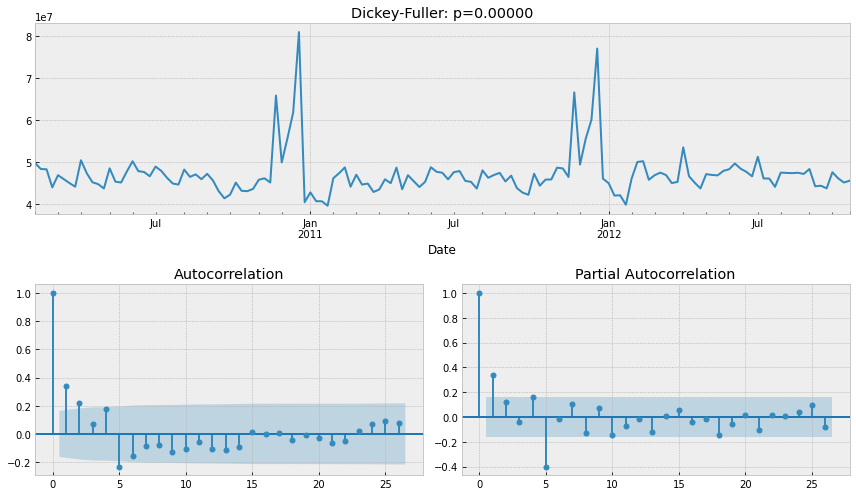

In [20]:
def tsplot(ts, lags):
    with plt.style.context("bmh"):    
        fig = plt.figure(figsize=(12, 7))
        ts_ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)
        acf_ax = plt.subplot2grid((2, 2), (1, 0))
        pacf_ax = plt.subplot2grid((2, 2), (1, 1))
        ts.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(ts)[1]
        ts_ax.set_title('Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(ts, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(ts, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(ts, 26)

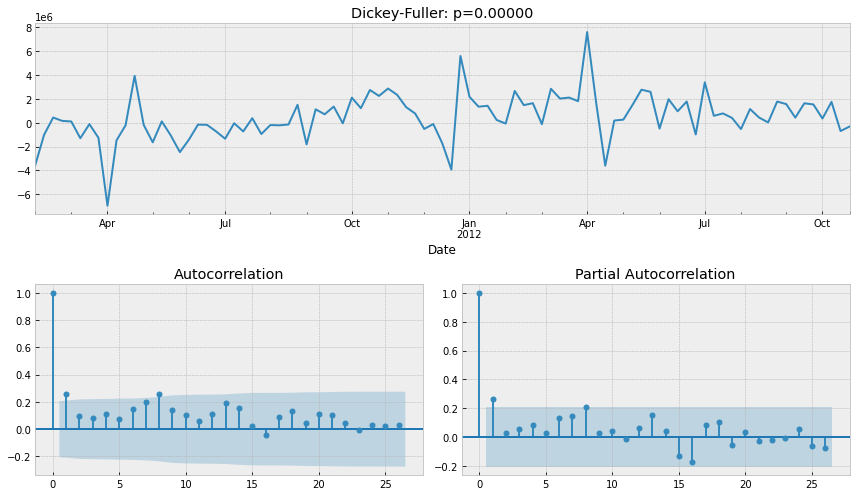

In [21]:
ts_diff = ts - ts.shift(52)
tsplot(ts_diff[52:], 26)

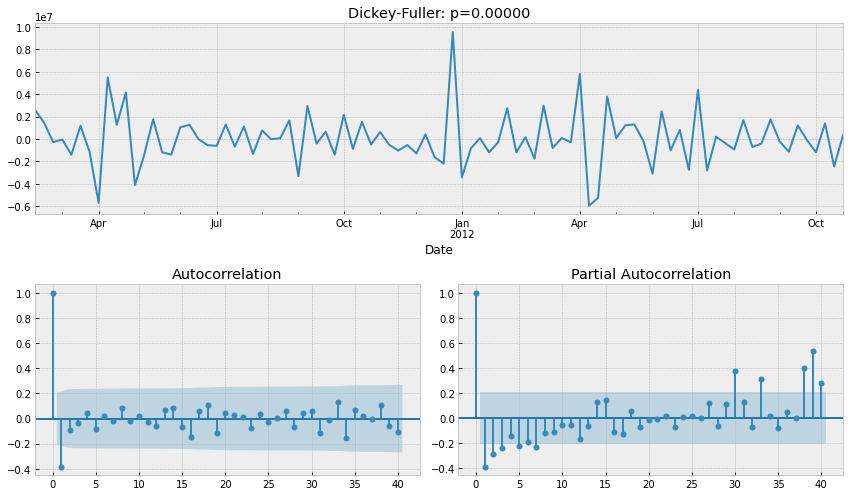

In [22]:
ts_diff = ts_diff - ts_diff.shift(1)
tsplot(ts_diff[52+1:], 40)

In [23]:
# Specify SARIMA Components & fit the model
p = 2
d=1 
q = 3
P = 2
D=1 
Q = 3
s = 52
model=sm.tsa.statespace.SARIMAX(ts, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(2, 1, 3)x(2, 1, 3, 52)   Log Likelihood               -1429.708
Date:                            Tue, 01 Feb 2022   AIC                           2881.416
Time:                                    10:54:28   BIC                           2908.914
Sample:                                02-05-2010   HQIC                          2892.505
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2929      0.251      5.157      0.000       0.802       1.784
ar.L2         -0.7493      0.236   

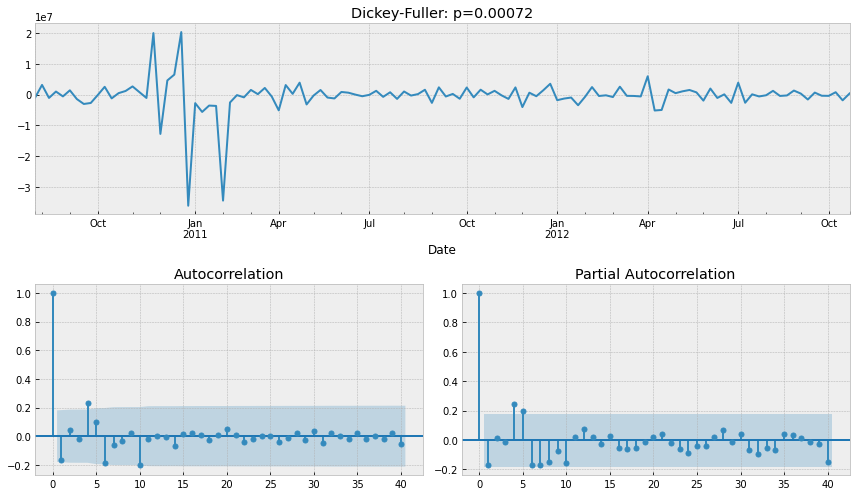

In [24]:
tsplot(model.resid[24+1:], lags=40)

In [25]:
# Culaculate MAE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
# Visualize MAE

def plotSARIMA(ts, model, n_steps):
    data = pd.DataFrame(ts)
    data.columns = ['actual']
    data['model'] = model.fittedvalues
    data['model'][:s+d] = np.NaN
    
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.model.append(forecast)
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['model'][s+d:])

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=data.index,
            y=data["actual"],
            name="Actual",
        ))
    fig.add_trace(
        go.Scatter(
            x=forecast.index,
            y=forecast,
            name="Model",
    ))
    fig.add_vrect(
    x0=data.index[-1], x1=forecast.index[-1],
    fillcolor="LightSalmon", opacity=0.5,
    layer="below", line_width=0)
    
    fig.update_layout(
        title=f"Time Series Revenue Forecast (MAPE: {error:.2f}%)",
        xaxis_title="weeks",
        yaxis_title="Revenue",
        yaxis_tickprefix = '$',
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"
        ))
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()
    
plotSARIMA(ts, model, 26)

# Model 3: Linear Models

<AxesSubplot:>

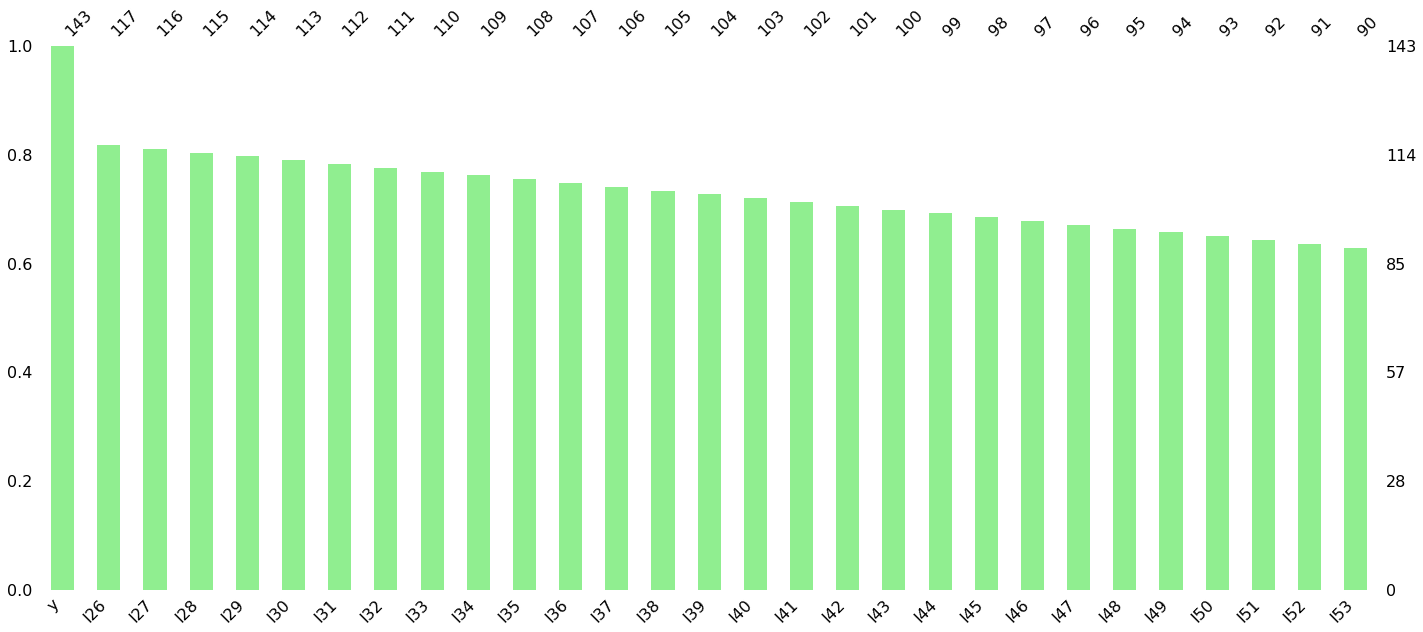

In [27]:
# Adding lags
l_ts = pd.DataFrame(ts)
l_ts.columns = ["y"]

for i in range(26, 54):
    l_ts[f"l{i}"] = l_ts.y.shift(i)
    
msno.bar(l_ts,color="lightgreen")

(90, 29)

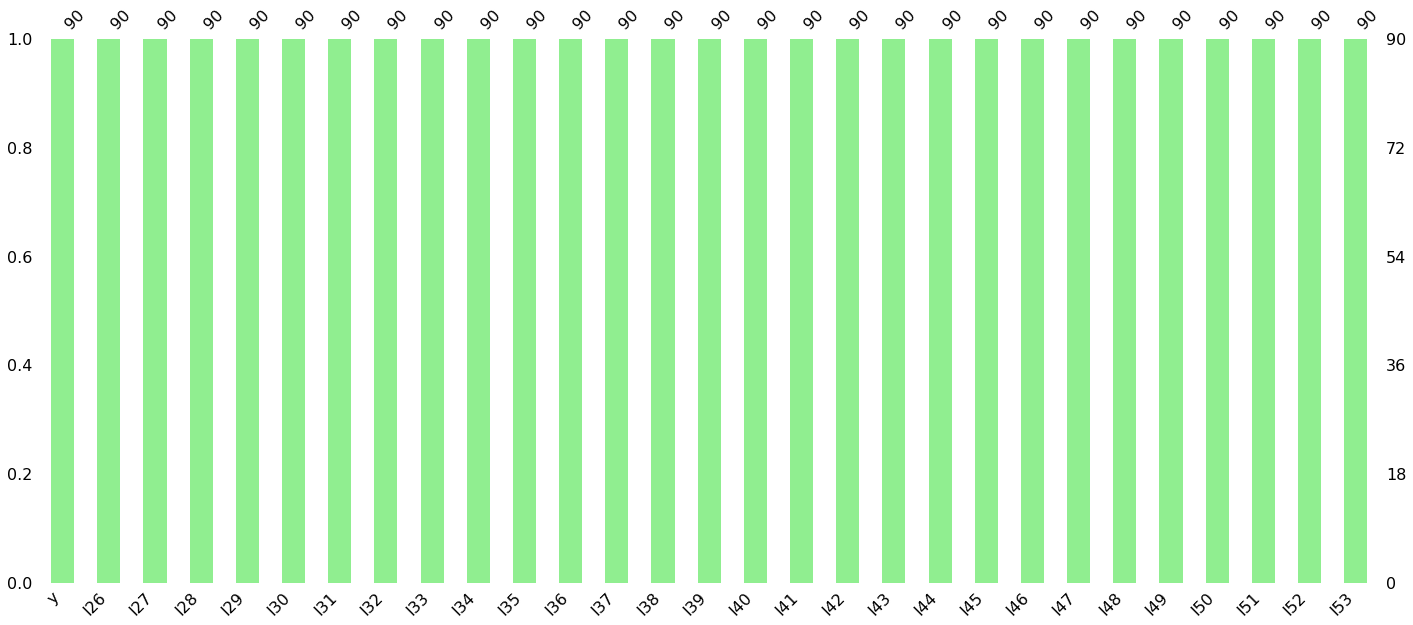

In [28]:
# Drop NANs
l_ts.dropna(inplace=True)
msno.bar(l_ts,color="lightgreen");
l_ts.shape

In [29]:
 #  5 folds cross-validation
tscv = TimeSeriesSplit(n_splits=5)

def ts_train_test_split(X, y, test_size):
    index = int(test_size*len(X))+1
    
    X_train = X.iloc[:-index]
    y_train = y.iloc[:-index]
    X_test = X.iloc[-index:]
    y_test = y.iloc[-index:]
    
    return X_train, X_test, y_train, y_test

In [30]:
# Visualize the Mean Absolute error
def plotLMResults(model, X_train, X_test):
    pred = model.predict(X_test)
    
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=X.index,
            y=y,
            name="Actual",
        ))
    fig.add_trace(
        go.Scatter(
            x=X_test.index,
            y=pred,
            name="Model",
        ))

    cv = cross_val_score(model, X_train, y_train, cv=tscv, scoring="neg_mean_squared_error")
    
    deviation = np.sqrt(cv.std())
    lower = pred - (1.5 * deviation)
    upper = pred + (1.5 * deviation)
    
    fig.add_trace(
        go.Scatter(
            x=X_test.index,
            y=lower,
            name="lower bond",
            line = dict(shape = 'linear', color = 'rgb(255, 12, 24)', width=0.7, dash = 'dash')
        ))
    fig.add_trace(
        go.Scatter(
            x=X_test.index,
            y=upper,
            name="upper bond",
            line = dict(shape = 'linear', color = 'rgb(255, 12, 24)', width=0.7, dash = 'dash')
        ))
    
    error = mean_absolute_percentage_error(pred, y_test)
    fig.update_layout(
        title=f"Mean Absolute Percentage Error: {error:.2f}%",
        xaxis_title="weeks",
        yaxis_title="sales",
        yaxis_tickprefix = '$',
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"
        ))
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()
    
def plotCoefs(model):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    fig = px.bar(coefs.coef)
    fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='gold')
    fig.show()
    

y = l_ts.y
X = l_ts.drop(['y'], axis=1)

X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_size=0.3)

lr = LinearRegression()
lr.fit(X_train, y_train)

plotLMResults(lr, X_train, X_test)
plotCoefs(lr)

with only adding a few lags to our linear model, we can get almost the same results as the SARIMA model. 

# Model 4: XGBoost

In [41]:
holidays = train.groupby(["Date"])["IsHoliday"].agg(lambda x: bool(any(x))).sort_index()
fig = px.line(ts, title='Holidays')

for holiday in holidays[holidays].index:
    fig.add_vrect(
        x0=holiday- timedelta(weeks=1) , x1=holiday,
        fillcolor="LightSalmon", opacity=0.7,
        layer="below", line_width=0)

fig.show()

In [42]:
# Tempreture by date
temperature = features.groupby(["Date"])["Temperature"].mean().sort_index()
fig = px.scatter(ts, title='Temperature', color=ts.index.map(lambda x: round(temperature[x])),
                 color_continuous_scale=["blue", "yellow", "red"], labels={"color":"Temperature","value":"total sales"})
fig.update_traces(mode='lines+markers')
fig.update_yaxes(tickprefix="$")
fig.show()

In [43]:
# Fuel prices by date
fuel_price = features.groupby(["Date"])["Fuel_Price"].mean().sort_index()
fig = px.scatter(ts, title='Fuel Price', color=ts.index.map(lambda x: round(fuel_price[x],2)),
                 labels={"color":"Fuel Price","value":"total sales"})
fig.update_traces(mode='lines+markers')
fig.update_yaxes(tickprefix="$")
fig.show()

In [44]:
ts.index[0], ts.index[0]-timedelta(weeks=0)

(Timestamp('2010-02-05 00:00:00'), Timestamp('2010-02-05 00:00:00'))

## Fitting the model

In [45]:
lxgb_ts = l_ts.copy()
for i in range(0,8):
    lxgb_ts[f"h{i}"] = lxgb_ts.index.map(lambda x: holidays[x-timedelta(weeks=i)])
    lxgb_ts[f"t{i}"] = lxgb_ts.index.map(lambda x: temperature[x-timedelta(weeks=i)])
    lxgb_ts[f"f{i}"] = lxgb_ts.index.map(lambda x: fuel_price[x-timedelta(weeks=i)])

In [46]:
standard_scaler = StandardScaler()

y = lxgb_ts.y
X = lxgb_ts.drop(['y'], axis=1)

X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_size=0.3)

X_train_standard = pd.DataFrame(standard_scaler.fit_transform(X_train)).set_index(X_train.index)
X_test_standard =  pd.DataFrame(standard_scaler.transform(X_test)).set_index(X_test.index)

In [47]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_standard, y_train)

plotLMResults(xgb, X_train_standard, X_test_standard)

# stores

In [48]:
# Stores Time series
sts = train.groupby(["Store","Date"])["Weekly_Sales"].sum().reset_index()

In [49]:
# Display top rows
sts.head()

,Store,Date,Weekly_Sales
0,1,2010-02-05,1643690.90
1,1,2010-02-12,1641957.44
2,1,2010-02-19,1611968.17
3,1,2010-02-26,1409727.59
4,1,2010-03-05,1554806.68


In [50]:
vsts = sts.groupby(["Store"])["Weekly_Sales"].agg(["sum","mean"]).reset_index()
fig = px.bar(vsts, x='Store', y='sum',
             hover_data=['Store', 'sum', 'mean'], color='mean',
             labels={'sum':'Weekly Sales'}, height=400)
fig.show()

In [51]:
# Walmart weekly sales by Store and Date(Using Plotly)
fig = go.Figure()
for s in sts.Store.unique():
    fig.add_trace(
        go.Scatter(
            x=sts[sts.Store==s].Date,
            y=sts[sts.Store==s].Weekly_Sales,
            name="Store_"+str(s)
        ))
fig.show()

The highest sales were on Dec/24 and Dec/23, these are thanksgiving holidays.

In [52]:
l_sts = pd.DataFrame()
for s in sts.Store.unique():
    df = pd.DataFrame(sts[sts.Store==s])
    for i in range(26, 54):
        df[f"l{i}"] = df.Weekly_Sales.shift(i)
    df.dropna(inplace=True)    
    l_sts = l_sts.append(df)

In [53]:
l_sts = l_sts.set_index("Date")
l_sts.head()

,Store,Weekly_Sales,l26,l27,l28,l29,l30,l31,l32,l33,...,l44,l45,l46,l47,l48,l49,l50,l51,l52,l53
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-11,1,1649614.93,1508237.76,1605491.78,1371986.60,1385065.20,1448938.92,1546074.18,1492418.14,1422711.60,...,1545418.53,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68,1409727.59,1611968.17,1641957.44,1643690.90
2011-02-18,1,1686842.78,1513080.49,1508237.76,1605491.78,1371986.60,1385065.20,1448938.92,1546074.18,1492418.14,...,1466058.28,1545418.53,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68,1409727.59,1611968.17,1641957.44
2011-02-25,1,1456800.28,1449142.92,1513080.49,1508237.76,1605491.78,1371986.60,1385065.20,1448938.92,1546074.18,...,1391256.12,1466058.28,1545418.53,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68,1409727.59,1611968.17
2011-03-04,1,1636263.41,1540163.53,1449142.92,1513080.49,1508237.76,1605491.78,1371986.60,1385065.20,1448938.92,...,1425100.71,1391256.12,1466058.28,1545418.53,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68,1409727.59
2011-03-11,1,1553191.63,1507460.69,1540163.53,1449142.92,1513080.49,1508237.76,1605491.78,1371986.60,1385065.20,...,1603955.12,1425100.71,1391256.12,1466058.28,1545418.53,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68


In [54]:
def sts_train_test_split(l_sts, test_size):
    train_set = pd.concat([l_sts[l_sts.Store==s].iloc[:-int(test_size*len(l_sts[l_sts.Store==1]))+1] for s in l_sts.Store.unique()])
    test_set = pd.concat([l_sts[l_sts.Store==s].iloc[-int(test_size*len(l_sts[l_sts.Store==1]))+1:] for s in l_sts.Store.unique()])
    
    y_train = train_set.Weekly_Sales
    X_train = train_set.drop(['Weekly_Sales'], axis=1)
    
    y_test = test_set.Weekly_Sales
    X_test = test_set.drop(['Weekly_Sales'], axis=1)
    return X_train, X_test, y_train, y_test

In [55]:
X_train, X_test, y_train, y_test = sts_train_test_split(l_sts, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3285, 29), (765, 29), (3285,), (765,))

In [56]:
standard_scaler = StandardScaler()
X_train_standard = pd.DataFrame(standard_scaler.fit_transform(X_train)).set_index(X_train.index)
X_test_standard =  pd.DataFrame(standard_scaler.transform(X_test)).set_index(X_test.index)

In [57]:
xgb = XGBRegressor()
xgb.fit(X_train_standard, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [58]:
pred = xgb.predict(X_test_standard)
matest = X_test.copy()
matest["Pred_Sales"] = pred
matest["Actual_Sales"] = y_test
matest.head()

,Store,l26,l27,l28,l29,l30,l31,l32,l33,l34,...,l46,l47,l48,l49,l50,l51,l52,l53,Pred_Sales,Actual_Sales
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-06,1,1550369.92,1497462.72,2270188.99,1881176.67,1799682.38,1584083.95,2033320.66,1539483.70,1594938.89,...,1530761.43,1525147.09,1624383.75,1352219.79,1396926.82,1455119.97,1534849.64,1488538.09,1604069.500,1769854.16
2012-07-13,1,1459601.17,1550369.92,1497462.72,2270188.99,1881176.67,1799682.38,1584083.95,2033320.66,1539483.70,...,1464693.46,1530761.43,1525147.09,1624383.75,1352219.79,1396926.82,1455119.97,1534849.64,1499004.375,1527014.04
2012-07-20,1,1394393.84,1459601.17,1550369.92,1497462.72,2270188.99,1881176.67,1799682.38,1584083.95,2033320.66,...,1550229.22,1464693.46,1530761.43,1525147.09,1624383.75,1352219.79,1396926.82,1455119.97,1468336.875,1497954.76
2012-07-27,1,1319325.59,1394393.84,1459601.17,1550369.92,1497462.72,2270188.99,1881176.67,1799682.38,1584083.95,...,1540471.24,1550229.22,1464693.46,1530761.43,1525147.09,1624383.75,1352219.79,1396926.82,1409260.375,1439123.71
2012-08-03,1,1636339.65,1319325.59,1394393.84,1459601.17,1550369.92,1497462.72,2270188.99,1881176.67,1799682.38,...,1514259.78,1540471.24,1550229.22,1464693.46,1530761.43,1525147.09,1624383.75,1352219.79,1670510.875,1631135.79


In [59]:
fig = go.Figure()
for s in range(1,5):
    fig.add_trace(
        go.Scatter(
            x=matest[matest.Store==s].index,
            y=matest[matest.Store==s].Pred_Sales,
            name="Store_"+str(s)+"_pred"
        ))
    fig.add_trace(
        go.Scatter(
            x=matest[matest.Store==s].index,
            y=matest[matest.Store==s].Actual_Sales,
            name="Store_"+str(s)+"_actual",
            line = dict(shape = 'linear', color = 'rgb(255, 12, 24)', width=0.7, dash = 'dash')
        ))
error = mean_absolute_percentage_error(pred, y_test)
fig.update_layout(
    title=f"Mean Absolute Percentage Error: {error:.2f}%",
    xaxis_title="weeks",
    yaxis_title="sales",
    yaxis_tickprefix = '$',
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [60]:
store = tdf.groupby(["Store","Size","Type"])["Weekly_Sales"].sum().reset_index()


fig = px.bar(store, x='Store', y="Weekly_Sales",
             hover_data=['Store', 'Weekly_Sales'], color='Type',height=400, title="Weekly_Sales by Store Type")
fig.show()


fig = px.bar(store, x='Store', y="Weekly_Sales",
             hover_data=['Store', 'Size'], color='Size', height=400, title="Weekly_Sales by Store Size")
fig.show()

In [61]:
lxgb_sts = pd.DataFrame()
for s in sts.Store.unique():
    df = pd.DataFrame(sts[sts.Store==s]).set_index("Date")
    for i in range(26, 54):
        df[f"l{i}"] = df.Weekly_Sales.shift(i)
    
    df.dropna(inplace=True)    
    lxgb_sts = lxgb_sts.append(df)
    
for i in range(0,12):
        lxgb_sts[f"h{i}"] = lxgb_sts.index.map(lambda x: holidays[x-timedelta(weeks=i)])
        lxgb_sts[f"t{i}"] = lxgb_sts.index.map(lambda x: temperature[x-timedelta(weeks=i)])
        lxgb_sts[f"f{i}"] = lxgb_sts.index.map(lambda x: fuel_price[x-timedelta(weeks=i)])
        
lxgb_sts["Size"] = lxgb_sts.Store.map(lambda x: store[store.Store==x]["Size"].item())
lxgb_sts["Type"] = lxgb_sts.Store.map(lambda x: store[store.Store==x]["Type"].item()).astype('category').cat.codes

In [62]:
X_train, X_test, y_train, y_test = sts_train_test_split(lxgb_sts, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3285, 67), (765, 67), (3285,), (765,))

In [63]:
standard_scaler = StandardScaler()
X_train_standard = pd.DataFrame(standard_scaler.fit_transform(X_train)).set_index(X_train.index)
X_test_standard =  pd.DataFrame(standard_scaler.transform(X_test)).set_index(X_test.index)

In [64]:
xgb = XGBRegressor()
xgb.fit(X_train_standard, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
pred = xgb.predict(X_test_standard)
matest = X_test.copy()
matest["Pred_Sales"] = pred
matest["Actual_Sales"] = y_test
matest.head()

,Store,l26,l27,l28,l29,l30,l31,l32,l33,l34,...,h10,t10,f10,h11,t11,f11,Size,Type,Pred_Sales,Actual_Sales
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-06,1,1550369.92,1497462.72,2270188.99,1881176.67,1799682.38,1584083.95,2033320.66,1539483.70,1594938.89,...,False,62.776222,3.950911,False,61.355556,3.984289,151315,0,1575556.125,1769854.16
2012-07-13,1,1459601.17,1550369.92,1497462.72,2270188.99,1881176.67,1799682.38,1584083.95,2033320.66,1539483.70,...,False,64.676000,3.906756,False,62.776222,3.950911,151315,0,1512354.500,1527014.04
2012-07-20,1,1394393.84,1459601.17,1550369.92,1497462.72,2270188.99,1881176.67,1799682.38,1584083.95,2033320.66,...,False,64.838000,3.869689,False,64.676000,3.906756,151315,0,1444846.125,1497954.76
2012-07-27,1,1319325.59,1394393.84,1459601.17,1550369.92,1497462.72,2270188.99,1881176.67,1799682.38,1584083.95,...,False,67.638222,3.834422,False,64.838000,3.869689,151315,0,1423661.125,1439123.71
2012-08-03,1,1636339.65,1319325.59,1394393.84,1459601.17,1550369.92,1497462.72,2270188.99,1881176.67,1799682.38,...,False,71.795556,3.788378,False,67.638222,3.834422,151315,0,1632125.375,1631135.79


In [66]:
fig = go.Figure()
for s in range(1,5):
    fig.add_trace(
        go.Scatter(
            x=matest[matest.Store==s].index,
            y=matest[matest.Store==s].Pred_Sales,
            name="Store_"+str(s)+"_pred"
        ))
    fig.add_trace(
        go.Scatter(
            x=matest[matest.Store==s].index,
            y=matest[matest.Store==s].Actual_Sales,
            name="Store_"+str(s)+"_actual",
            line = dict(shape = 'linear', color = 'rgb(255, 12, 24)', width=0.7, dash = 'dash')
        ))
error = mean_absolute_percentage_error(pred, y_test)
fig.update_layout(
    title=f"Mean Absolute Percentage Error: {error:.2f}%",
    xaxis_title="weeks",
    yaxis_title="sales",
    yaxis_tickprefix = '$',
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))
fig.update_xaxes(rangeslider_visible=True)
fig.show()

***